<a href="https://colab.research.google.com/github/sokrypton/algosb_2021/blob/main/msa_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install and load models

In [1]:
# for other models see: https://github.com/facebookresearch/esm#main-models-you-should-use-

# mount google-drive, download to google-drive,
# will run faster next time!
'''
import os
import torch
hub_dir = "/content/drive/MyDrive/AlgoSB"
if not os.path.isdir(hub_dir): os.mkdir(hub_dir)
torch.hub.set_dir(hub_dir)
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm_msa1b_t12_100M_UR50S")
'''

# this step will take ~2 mins
import torch
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm_msa1b_t12_100M_UR50S")

Downloading: "https://github.com/facebookresearch/esm/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm_msa1b_t12_100M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm_msa1b_t12_100M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm_msa1b_t12_100M_UR50S-contact-regression.pt


In [2]:
# put model on GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model = model.eval()
model.args.token_dropout = False

# alphabet size
esm_alphabet_len = len(alphabet.all_toks)
esm_alphabet = "".join(alphabet.all_toks[4:24])+"-"

In [3]:
!wget -qnc https://raw.githubusercontent.com/sokrypton/algosb_2021/main/utils.py
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import softmax
from utils import *

# analyze MSA

In [4]:
# RL29_ECOLI (essential ribosomal protein from ECOLI)
!wget -qnc https://files.ipd.uw.edu/krypton/RL29.uni.1e-10.i8.i90c75.a3m
headers, seqs = parse_fasta("RL29.uni.1e-10.i8.i90c75.a3m", a3m = True)
msa = mk_msa(seqs, alphabet=esm_alphabet)
seq = seqs[0]
print(msa.shape)
print(seq)

(11367, 63, 21)
MKAKELREKSVEELNTELLNLLREQFNLRMQAASGQLQQSHLLKQVRRDVARVKTLLNEKAGA


In [9]:
def get_categorical_jacobian(seqs, k=0):
  # ∂in/∂out
  # k controls which sequence jacobian is computed over
  MSA = [("none",seq) for seq in seqs]
  x = alphabet.get_batch_converter()(MSA)[-1]
  ln = len(seqs[0])
  with torch.no_grad():
    f = lambda x: model(x)["logits"][0,k,1:(ln+1),4:24].cpu().numpy()
    x = x.cuda()
    fx = f(x)
    fx_h = np.zeros((ln,20,ln,20))
    for n in range(ln): # for each position
      print(n)
      for a in range(20): # try all 20 mutations
        x_h = torch.clone(x)
        x_h[0,k,n+1] = a+4
        fx_h[n,a] = f(x_h)
    return fx - fx_h

In [10]:
%%time
# select subset of sequences
np.random.seed(0)
idx = np.append(0,np.random.permutation(np.arange(1,len(seqs))))[:100]
sub_seqs = [seqs[i] for i in idx] 

# run (note can take ~30 mins to run)
jac = get_categorical_jacobian(sub_seqs)

CPU times: user 21min 27s, sys: 1.02 s, total: 21min 28s
Wall time: 21min 23s


In [13]:
jac = J

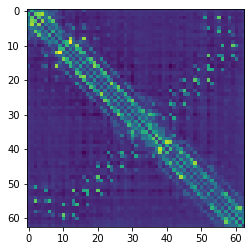

In [11]:
plt.imshow(get_contacts(J))

In [12]:
# inverse_covariance of natural msa
tmp = inv_cov_jax(msa)
L = len(seq)
ic = tmp["ic"].reshape(L,21,L,21)[:,:20,:,:20]

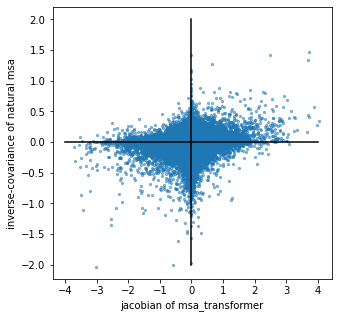

In [15]:
idx = np.triu_indices(L,1)
plt.figure(figsize=(5,5))
plt.scatter(jac[idx[0],:,idx[1],:],
            ic[idx[0],:,idx[1],:],s=5,alpha=0.5)
plt.xlabel("jacobian of msa_transformer")
plt.ylabel("inverse-covariance of natural msa")
plt.plot([0,0],[-2,2],color="black")
plt.plot([-4,4],[0,0],color="black")

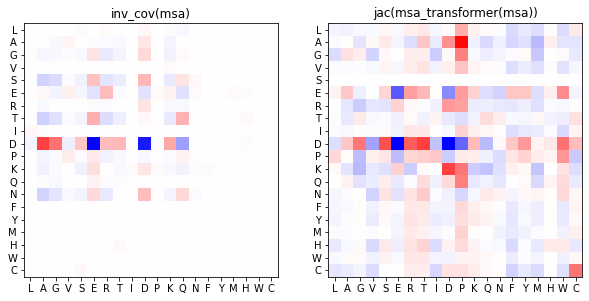

In [16]:
i = 9
j = 12

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); 
plt.title("inv_cov(msa)");
plt.imshow(ic[i,:,j,:],vmin=-1.5,vmax=1.5,cmap="bwr_r")
plt.xticks(range(20),esm_alphabet[:20])
plt.yticks(range(20),esm_alphabet[:20])

plt.subplot(1,2,2);
plt.title("jac(msa_transformer(msa))");
plt.imshow(jac[i,:,j,:],vmin=-3,vmax=3,cmap="bwr_r")
plt.xticks(range(20),esm_alphabet[:20])
plt.yticks(range(20),esm_alphabet[:20])
plt.show()